## Beyond Merrity zadatak

In [428]:
# Imports
import pandas as pd
import re
from deep_translator import GoogleTranslator
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Display full DataFrames
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

# Read data (promijeniti putanju do datoteke)
train = pd.read_excel('D:/Documents/Posao/Prijave/Spona_code/Zadatak/train.xlsx')
test = pd.read_excel('D:/Documents/Posao/Prijave/Spona_code/Zadatak/test.xlsx')

In [429]:
# Create sentiment categories

minus_three = {'stalno',
'previše',
'nema',
'nema ravnoteže',
'neravnoteže',
'na strani poslovnog',
'nefleksibilnost'
}

minus_two = {'neravnoteža',
'loše',
'narušen' 
}

minus_one = {'manje privatnog života',
'nije najbolje',
'covid loše',
'manjak home-office',
'izazove',
'dosta malo privatnog'
}

zero = {'kako kad', 'nije kod svih isto'}

one = {'može bolje',
'raditi sam na tome',
'kompromisi',
'ovisno',
'ovisi'
}

two = {'ovisi o meni',
'podnošljivo',
'povremeno optimalno',
'balansirano'
}

three = {'pozitivno',
'zadovoljna',
'zadovoljan',
'ok',
'fair',
'balans',
'dobro',
'postoji balans',
'pozitivno iskustvo', 
'dobro',
'fleksibilnost',
'dobar',
'ok je',
}

four = {'odlično',
'ravnoteža u potpunosti',
'vrlo zadovoljna',
'uravnoteženo',
'dobra ravnoteža',
'uravnoteženo',
'fleksibilno', 
'otvorenog uma', 
'prihvatljivo',
'balansirano',
'vrlo dobro',
}

five = {'sklad', 'super'}

In [430]:
# Determine sentiment on predefined categories

def get_sentiment(sentence):
  sent=0
  words = [word.lower() for word in nltk.word_tokenize(sentence)]
  for word in words:
    if word in minus_three:
      sent -= 3
    elif word in minus_two:
      sent -= 2
    elif word in minus_one:
      sent -= 1
    elif word in one:
      sent += 1
    elif word in two:
      sent += 2
    elif word in three:
      sent += 3
    elif word in four:
      sent += 4
    elif word in five:
      sent += 5
    if sent > 5:
        sent = 5
    if sent < -5:
        sent = -5
  return sent

In [431]:
test['my_sentiment'] = test['review'].apply(get_sentiment)
test

,review,my_sentiment
0,"Pojedini djelatnici imaju ravnotežu, dok neki koji se žele više truditi i raditi pretpostavljam da im poslovni dio na neki način ulazi i u privatni dio.",0
1,Relativno dobar balans.,5
2,U redu je,0
3,Posve primjereno,0
4,Odlično,4
5,prolazno,0
6,Poslovni zadire u privatni na dnevnoj razini,0
7,Relativno je ok,3
8,Odlično,4
9,dobro,3


- nedostaje puno riječi, pa je puno rezultata 0
- za riječi iz riječnika relativno dobri rezultati

## Preprocessing

In [432]:
# Translate to english
translator = GoogleTranslator(source='hr', target='en')

for i in range(len(train)):
    train.loc[i, 'review_en'] = translator.translate(train.loc[i, 'review'])  

In [433]:
# Clean, remove punctuation, digits...
def clean(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

train['clean_reviews'] = train['review_en'].apply(clean)
train

,review,sentiment,review_en,clean_reviews
0,previše prekovremenih,-3,too many overtime,too many overtime
1,može bolje,1,can do better,can do better
2,home office donosi manje privatnog života,-1,Home office brings less private life,Home office brings less private life
3,nije najbolje,-1,not the best,not the best
4,covid loše,-1,covid bad,covid bad
5,manjak ravnoteže dok smo u home-office režimu,-1,lack of balance while in home-office mode,lack of balance while in home office mode
6,svatko mora raditi sam na tome,1,everyone has to work on it alone,everyone has to work on it alone
7,pozitivno,3,positively,positively
8,nema je,-3,she is gone,she is gone
9,zadovoljna,3,satisfied,satisfied


In [434]:
# Remove stopwords and tag parts of speech

sw = nltk.corpus.stopwords.words('english')
not_sw = {'not', 'no', 'can', 'do', 'very'} 
new_sw = set([word for word in sw if word not in not_sw])


pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    for word, tag in tags:
        if word.lower() not in new_sw:
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
    return newlist

train['pos'] = train['clean_reviews'].apply(token_stop_pos)
train

,review,sentiment,review_en,clean_reviews,pos
0,previše prekovremenih,-3,too many overtime,too many overtime,"[(many, a), (overtime, n)]"
1,može bolje,1,can do better,can do better,"[(can, None), (do, v), (better, a)]"
2,home office donosi manje privatnog života,-1,Home office brings less private life,Home office brings less private life,"[(Home, n), (office, n), (brings, v), (less, a), (private, a), (life, n)]"
3,nije najbolje,-1,not the best,not the best,"[(not, r), (best, a)]"
4,covid loše,-1,covid bad,covid bad,"[(covid, n), (bad, a)]"
5,manjak ravnoteže dok smo u home-office režimu,-1,lack of balance while in home-office mode,lack of balance while in home office mode,"[(lack, n), (balance, n), (home, n), (office, n), (mode, n)]"
6,svatko mora raditi sam na tome,1,everyone has to work on it alone,everyone has to work on it alone,"[(everyone, n), (work, v), (alone, r)]"
7,pozitivno,3,positively,positively,"[(positively, r)]"
8,nema je,-3,she is gone,she is gone,"[(gone, v)]"
9,zadovoljna,3,satisfied,satisfied,"[(satisfied, a)]"


In [435]:
# Create lemmas
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

train['lemma'] = train['pos'].apply(lemmatize)
train

,review,sentiment,review_en,clean_reviews,pos,lemma
0,previše prekovremenih,-3,too many overtime,too many overtime,"[(many, a), (overtime, n)]",many overtime
1,može bolje,1,can do better,can do better,"[(can, None), (do, v), (better, a)]",can do good
2,home office donosi manje privatnog života,-1,Home office brings less private life,Home office brings less private life,"[(Home, n), (office, n), (brings, v), (less, a), (private, a), (life, n)]",Home office bring less private life
3,nije najbolje,-1,not the best,not the best,"[(not, r), (best, a)]",not best
4,covid loše,-1,covid bad,covid bad,"[(covid, n), (bad, a)]",covid bad
5,manjak ravnoteže dok smo u home-office režimu,-1,lack of balance while in home-office mode,lack of balance while in home office mode,"[(lack, n), (balance, n), (home, n), (office, n), (mode, n)]",lack balance home office mode
6,svatko mora raditi sam na tome,1,everyone has to work on it alone,everyone has to work on it alone,"[(everyone, n), (work, v), (alone, r)]",everyone work alone
7,pozitivno,3,positively,positively,"[(positively, r)]",positively
8,nema je,-3,she is gone,she is gone,"[(gone, v)]",go
9,zadovoljna,3,satisfied,satisfied,"[(satisfied, a)]",satisfied


## TextBlob

In [436]:
# TextBlob polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

In [437]:
train['polarity'] = train['lemma'].apply(getPolarity) 
train.head()

,review,sentiment,review_en,clean_reviews,pos,lemma,polarity
0,previše prekovremenih,-3,too many overtime,too many overtime,"[(many, a), (overtime, n)]",many overtime,0.500000
1,može bolje,1,can do better,can do better,"[(can, None), (do, v), (better, a)]",can do good,0.700000
2,home office donosi manje privatnog života,-1,Home office brings less private life,Home office brings less private life,"[(Home, n), (office, n), (brings, v), (less, a), (private, a), (life, n)]",Home office bring less private life,-0.083333
3,nije najbolje,-1,not the best,not the best,"[(not, r), (best, a)]",not best,-0.500000
4,covid loše,-1,covid bad,covid bad,"[(covid, n), (bad, a)]",covid bad,-0.700000


In [438]:
# Rescale polarity to get in range of sentiment (-5 - 5 instead of -1 - 1)

def rescale(col):
    if col >= -1 and col < -0.8:
        col = -5
    elif col >= -0.8 and col <= -0.6:
        col = -4
    elif col >= -0.6 and  col <= -0.4:
        col = -3
    elif col >= -0.4 and  col <= -0.2:
        col = -2
    elif col >= -0.2 and  col < 0:
        col = -1
    elif col == 0:
        col = 0
    elif col >= 0 and  col <= 0.2:
        col = 1
    elif col >= 0.2 and  col <= 0.4:
        col = 2
    elif col >= 0.4 and  col <= 0.6:
        col = 3
    elif col >= 0.6 and  col < 0.8:
        col = 4
    else:
        col = 5
    return col

train['blob_sentiment'] = train['polarity'].apply(rescale)
train

,review,sentiment,review_en,clean_reviews,pos,lemma,polarity,blob_sentiment
0,previše prekovremenih,-3,too many overtime,too many overtime,"[(many, a), (overtime, n)]",many overtime,0.500000,3
1,može bolje,1,can do better,can do better,"[(can, None), (do, v), (better, a)]",can do good,0.700000,4
2,home office donosi manje privatnog života,-1,Home office brings less private life,Home office brings less private life,"[(Home, n), (office, n), (brings, v), (less, a), (private, a), (life, n)]",Home office bring less private life,-0.083333,-1
3,nije najbolje,-1,not the best,not the best,"[(not, r), (best, a)]",not best,-0.500000,-3
4,covid loše,-1,covid bad,covid bad,"[(covid, n), (bad, a)]",covid bad,-0.700000,-4
5,manjak ravnoteže dok smo u home-office režimu,-1,lack of balance while in home-office mode,lack of balance while in home office mode,"[(lack, n), (balance, n), (home, n), (office, n), (mode, n)]",lack balance home office mode,0.000000,0
6,svatko mora raditi sam na tome,1,everyone has to work on it alone,everyone has to work on it alone,"[(everyone, n), (work, v), (alone, r)]",everyone work alone,0.000000,0
7,pozitivno,3,positively,positively,"[(positively, r)]",positively,0.227273,2
8,nema je,-3,she is gone,she is gone,"[(gone, v)]",go,0.000000,0
9,zadovoljna,3,satisfied,satisfied,"[(satisfied, a)]",satisfied,0.500000,3


## TextBlob test

In [439]:
# Translate, clean... the test set in the same way

for i in range(len(test)):
    test.loc[i, 'review_en'] = translator.translate(test.loc[i, 'review']) 

test['clean_reviews'] = test['review_en'].apply(clean)

test['pos'] = test['clean_reviews'].apply(token_stop_pos)

test['lemma'] = test['pos'].apply(lemmatize)

test['polarity'] = test['lemma'].apply(getPolarity)
test['blob_sentiment'] = test['polarity'].apply(rescale)

test

,review,my_sentiment,review_en,clean_reviews,pos,lemma,polarity,blob_sentiment
0,"Pojedini djelatnici imaju ravnotežu, dok neki koji se žele više truditi i raditi pretpostavljam da im poslovni dio na neki način ulazi i u privatni dio.",0,"Some employees have a balance, while some who want to work harder and work, I guess that their business part somehow enters the private part.",Some employees have a balance while some who want to work harder and work I guess that their business part somehow enters the private part,"[(employees, n), (balance, n), (want, v), (work, v), (harder, n), (work, n), (guess, v), (business, n), (part, n), (somehow, n), (enters, v), (private, a), (part, n)]",employee balance want work harder work guess business part somehow enter private part,-0.050000,-1
1,Relativno dobar balans.,5,Relatively good balance.,Relatively good balance,"[(Relatively, r), (good, a), (balance, n)]",Relatively good balance,0.700000,4
2,U redu je,0,It is OK,It is OK,"[(OK, a)]",OK,0.500000,3
3,Posve primjereno,0,Quite appropriate,Quite appropriate,"[(Quite, r), (appropriate, a)]",Quite appropriate,0.500000,3
4,Odlično,4,Great,Great,"[(Great, n)]",Great,0.800000,5
5,prolazno,0,transient,transient,"[(transient, n)]",transient,0.000000,0
6,Poslovni zadire u privatni na dnevnoj razini,0,Business intrudes into the private on a daily basis,Business intrudes into the private on a daily basis,"[(Business, n), (intrudes, n), (private, a), (daily, a), (basis, n)]",Business intrudes private daily basis,0.000000,0
7,Relativno je ok,3,It's relatively ok,It s relatively ok,"[(relatively, r), (ok, a)]",relatively ok,0.500000,3
8,Odlično,4,Great,Great,"[(Great, n)]",Great,0.800000,5
9,dobro,3,good,good,"[(good, a)]",good,0.700000,4


- također puno nula, kontekst se ne uzima u obzir 

## VADER

In [440]:
# Create vader analyzer, add new relevant words and weights

analyzer = SentimentIntensityAnalyzer()

new_words = {'overtime': -3.0, 'disturbed': -2.0,'compromise': 1.0, 'compromises': 1.0,
             'imbalance': -2.0,'no balance': -3.0, 'established': 4.0, 'depends': 0.0,
             'balanced': 3.0, 'harmony': 5.0, 'tolerably': 2.0, 'tolerable': 2.0,
             'flexibility': 3.0, 'flexible': 3.0, 'open-minded': 4.0, 'inflexibility': -3.0,
             'inflexible': -3.0}

analyzer.lexicon.update(new_words)
 
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

train['vader_polarity'] = train['review_en'].apply(vadersentimentanalysis)

In [441]:
# Rescale for easier comparisson with sentiment
train['vader_sentiment'] = train['vader_polarity'].apply(rescale)
train

,review,sentiment,review_en,clean_reviews,pos,lemma,polarity,blob_sentiment,vader_polarity,vader_sentiment
0,previše prekovremenih,-3,too many overtime,too many overtime,"[(many, a), (overtime, n)]",many overtime,0.500000,3,-0.6124,-4
1,može bolje,1,can do better,can do better,"[(can, None), (do, v), (better, a)]",can do good,0.700000,4,0.4404,3
2,home office donosi manje privatnog života,-1,Home office brings less private life,Home office brings less private life,"[(Home, n), (office, n), (brings, v), (less, a), (private, a), (life, n)]",Home office bring less private life,-0.083333,-1,0.0000,0
3,nije najbolje,-1,not the best,not the best,"[(not, r), (best, a)]",not best,-0.500000,-3,-0.5216,-3
4,covid loše,-1,covid bad,covid bad,"[(covid, n), (bad, a)]",covid bad,-0.700000,-4,-0.5423,-3
5,manjak ravnoteže dok smo u home-office režimu,-1,lack of balance while in home-office mode,lack of balance while in home office mode,"[(lack, n), (balance, n), (home, n), (office, n), (mode, n)]",lack balance home office mode,0.000000,0,-0.3182,-2
6,svatko mora raditi sam na tome,1,everyone has to work on it alone,everyone has to work on it alone,"[(everyone, n), (work, v), (alone, r)]",everyone work alone,0.000000,0,-0.2500,-2
7,pozitivno,3,positively,positively,"[(positively, r)]",positively,0.227273,2,0.5267,3
8,nema je,-3,she is gone,she is gone,"[(gone, v)]",go,0.000000,0,0.0000,0
9,zadovoljna,3,satisfied,satisfied,"[(satisfied, a)]",satisfied,0.500000,3,0.4215,3


## VADER test

In [442]:
# Apply VADER to test set and rescale
test['vader_polarity'] = test['review_en'].apply(vadersentimentanalysis)
test['vader_sentiment'] = test['vader_polarity'].apply(rescale)
test

,review,my_sentiment,review_en,clean_reviews,pos,lemma,polarity,blob_sentiment,vader_polarity,vader_sentiment
0,"Pojedini djelatnici imaju ravnotežu, dok neki koji se žele više truditi i raditi pretpostavljam da im poslovni dio na neki način ulazi i u privatni dio.",0,"Some employees have a balance, while some who want to work harder and work, I guess that their business part somehow enters the private part.",Some employees have a balance while some who want to work harder and work I guess that their business part somehow enters the private part,"[(employees, n), (balance, n), (want, v), (work, v), (harder, n), (work, n), (guess, v), (business, n), (part, n), (somehow, n), (enters, v), (private, a), (part, n)]",employee balance want work harder work guess business part somehow enter private part,-0.050000,-1,0.0772,1
1,Relativno dobar balans.,5,Relatively good balance.,Relatively good balance,"[(Relatively, r), (good, a), (balance, n)]",Relatively good balance,0.700000,4,0.4404,3
2,U redu je,0,It is OK,It is OK,"[(OK, a)]",OK,0.500000,3,0.4466,3
3,Posve primjereno,0,Quite appropriate,Quite appropriate,"[(Quite, r), (appropriate, a)]",Quite appropriate,0.500000,3,0.0000,0
4,Odlično,4,Great,Great,"[(Great, n)]",Great,0.800000,5,0.6249,4
5,prolazno,0,transient,transient,"[(transient, n)]",transient,0.000000,0,0.0000,0
6,Poslovni zadire u privatni na dnevnoj razini,0,Business intrudes into the private on a daily basis,Business intrudes into the private on a daily basis,"[(Business, n), (intrudes, n), (private, a), (daily, a), (basis, n)]",Business intrudes private daily basis,0.000000,0,0.0000,0
7,Relativno je ok,3,It's relatively ok,It s relatively ok,"[(relatively, r), (ok, a)]",relatively ok,0.500000,3,0.2960,2
8,Odlično,4,Great,Great,"[(Great, n)]",Great,0.800000,5,0.6249,4
9,dobro,3,good,good,"[(good, a)]",good,0.700000,4,0.4404,3


- bolje od textblob-a pošto se mogu dodati custom riječi

## Vectorizer, Supervised Learning

In [443]:
# Create Vectorizers
cvect = CountVectorizer(ngram_range=(1,1), max_features=100)
tfvect = TfidfVectorizer(ngram_range=(1,1), max_features=100)

csparse = cvect.fit_transform(train.review_en)
tfsparse = tfvect.fit_transform(train.review_en)

In [444]:
# Transform sparse matrix to dataframe
train_df = pd.DataFrame(csparse.toarray(), columns=cvect.get_feature_names())
train_df['sentiment'] = train.sentiment
train_df.shape

(55, 101)

In [445]:
# Train models and make predictions

bayes = MultinomialNB()
svc = LinearSVC()

X = train_df.drop('sentiment', axis=1)
y = train_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

bayes.fit(X_train, y_train)
svc.fit(X_train, y_train)

y_pred_b = bayes.predict(X_test)
print(y_pred_b)

y_pred_s = svc.predict(X_test)
print(y_pred_s)

print(list(y_test))

[ 4 -1  3  3  3  3  1  3  3  3  3 -3  3  3]
[ 4  3  3  3  3  3  2  4  4 -1  3  0  3  3]
[4, -1, 4, -2, -3, 3, 0, 4, 2, -2, -3, -1, 4, 5]


In [446]:
# Accuracy
print(accuracy_score(y_test, y_pred_b))
print(accuracy_score(y_test, y_pred_s))

0.21428571428571427
0.21428571428571427


## Vectorizer, Supervised Learning test

In [447]:
# Vectorize, transform to dataframe, predict
csparse_test = cvect.fit_transform(test.review_en)
test_df = pd.DataFrame(csparse_test.toarray(), columns=cvect.get_feature_names())
test_y_pred = bayes.predict(test_df)
test['bayes_sentiment'] = test_y_pred
test

,review,my_sentiment,review_en,clean_reviews,pos,lemma,polarity,blob_sentiment,vader_polarity,vader_sentiment,bayes_sentiment
0,"Pojedini djelatnici imaju ravnotežu, dok neki koji se žele više truditi i raditi pretpostavljam da im poslovni dio na neki način ulazi i u privatni dio.",0,"Some employees have a balance, while some who want to work harder and work, I guess that their business part somehow enters the private part.",Some employees have a balance while some who want to work harder and work I guess that their business part somehow enters the private part,"[(employees, n), (balance, n), (want, v), (work, v), (harder, n), (work, n), (guess, v), (business, n), (part, n), (somehow, n), (enters, v), (private, a), (part, n)]",employee balance want work harder work guess business part somehow enter private part,-0.050000,-1,0.0772,1,-3
1,Relativno dobar balans.,5,Relatively good balance.,Relatively good balance,"[(Relatively, r), (good, a), (balance, n)]",Relatively good balance,0.700000,4,0.4404,3,-3
2,U redu je,0,It is OK,It is OK,"[(OK, a)]",OK,0.500000,3,0.4466,3,3
3,Posve primjereno,0,Quite appropriate,Quite appropriate,"[(Quite, r), (appropriate, a)]",Quite appropriate,0.500000,3,0.0000,0,3
4,Odlično,4,Great,Great,"[(Great, n)]",Great,0.800000,5,0.6249,4,3
5,prolazno,0,transient,transient,"[(transient, n)]",transient,0.000000,0,0.0000,0,3
6,Poslovni zadire u privatni na dnevnoj razini,0,Business intrudes into the private on a daily basis,Business intrudes into the private on a daily basis,"[(Business, n), (intrudes, n), (private, a), (daily, a), (basis, n)]",Business intrudes private daily basis,0.000000,0,0.0000,0,3
7,Relativno je ok,3,It's relatively ok,It s relatively ok,"[(relatively, r), (ok, a)]",relatively ok,0.500000,3,0.2960,2,3
8,Odlično,4,Great,Great,"[(Great, n)]",Great,0.800000,5,0.6249,4,3
9,dobro,3,good,good,"[(good, a)]",good,0.700000,4,0.4404,3,3


- vrlo nizak accuracy, bilo bi bolje s većim setom za treniranje, a i onda bi se isplatilo namještati detalje modela i preprocessing-a

## Usporedba

In [448]:
train_pred = train[['review', 'review_en', 'sentiment', 'blob_sentiment', 'vader_sentiment']]
train_pred

,review,review_en,sentiment,blob_sentiment,vader_sentiment
0,previše prekovremenih,too many overtime,-3,3,-4
1,može bolje,can do better,1,4,3
2,home office donosi manje privatnog života,Home office brings less private life,-1,-1,0
3,nije najbolje,not the best,-1,-3,-3
4,covid loše,covid bad,-1,-4,-3
5,manjak ravnoteže dok smo u home-office režimu,lack of balance while in home-office mode,-1,0,-2
6,svatko mora raditi sam na tome,everyone has to work on it alone,1,0,-2
7,pozitivno,positively,3,2,3
8,nema je,she is gone,-3,0,0
9,zadovoljna,satisfied,3,3,3


<AxesSubplot:xlabel='vader_sentiment', ylabel='count'>

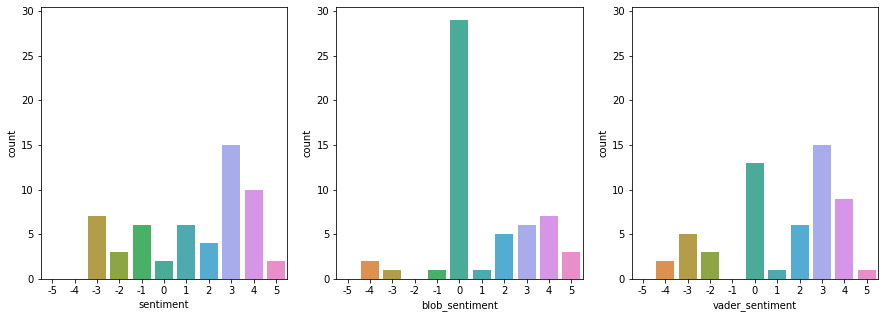

In [449]:
sentiment_range = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,3,1)
sns.countplot(data=train, x='sentiment', order=sentiment_range)
ax2 = plt.subplot(1,3,2, sharey=ax1)
sns.countplot(data=train, x='blob_sentiment', order=sentiment_range)
ax3 = plt.subplot(1,3,3, sharey=ax1)
sns.countplot(data=train, x='vader_sentiment', order=sentiment_range)

In [450]:
print('Blob Accuracy:', accuracy_score(train.sentiment, train.blob_sentiment))
print('VADER Accuracy', accuracy_score(train.sentiment, train.vader_sentiment))

Blob Accuracy: 0.2
VADER Accuracy 0.3090909090909091


In [451]:
test_pred = test[['review', 'review_en', 'my_sentiment', 'blob_sentiment', 'vader_sentiment', 'bayes_sentiment']]
test_pred

,review,review_en,my_sentiment,blob_sentiment,vader_sentiment,bayes_sentiment
0,"Pojedini djelatnici imaju ravnotežu, dok neki koji se žele više truditi i raditi pretpostavljam da im poslovni dio na neki način ulazi i u privatni dio.","Some employees have a balance, while some who want to work harder and work, I guess that their business part somehow enters the private part.",0,-1,1,-3
1,Relativno dobar balans.,Relatively good balance.,5,4,3,-3
2,U redu je,It is OK,0,3,3,3
3,Posve primjereno,Quite appropriate,0,3,0,3
4,Odlično,Great,4,5,4,3
5,prolazno,transient,0,0,0,3
6,Poslovni zadire u privatni na dnevnoj razini,Business intrudes into the private on a daily basis,0,0,0,3
7,Relativno je ok,It's relatively ok,3,3,2,3
8,Odlično,Great,4,5,4,3
9,dobro,good,3,4,3,3


<AxesSubplot:xlabel='bayes_sentiment', ylabel='count'>

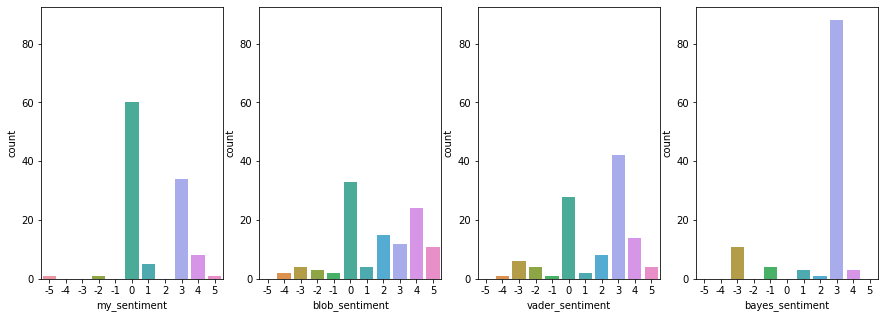

In [452]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,4,1)
sns.countplot(data=test, x='my_sentiment', order=sentiment_range)
ax2 = plt.subplot(1,4,2, sharey=ax1)
sns.countplot(data=test, x='blob_sentiment', order=sentiment_range)
ax3 = plt.subplot(1,4,3, sharey=ax1)
sns.countplot(data=test, x='vader_sentiment', order=sentiment_range)
ax4 = plt.subplot(1,4,4, sharey=ax1)
sns.countplot(data=test, x='bayes_sentiment', order=sentiment_range)

In [453]:
#train_pred.to_excel('D:/Documents/Posao/Prijave/Spona_code/Zadatak/train_pred.xlsx')
#test_pred.to_excel('D:/Documents/Posao/Prijave/Spona_code/Zadatak/test_pred.xlsx')

### Zaključak
- Određivanje sentimenta samo preko ručno definiranih kategorija riječi bi bilo bolje s više definiranih riječi ali vjerojatno bi bilo lakše koristiti preddefinirane (TextBlob, VADER...) iako u tom slučaju utječe i kvaliteta prijevoda
- TextBlob nizak accuracy jer ne uzima u obzir work-life balance kontekst
- Za supervised learning premalo uzoraka 
- Iako VADER daje najbolje rezultate jer je moguće dodati vlastite riječi i weights još uvijek je accuracy samo 30%
    - bilo bi bolje s više uzoraka i više dodanih riječi s preciznije određenim weights-ima
- čišćenje teksta (tokenizacija, lematizacija...) ili nije imalo utjecaja na rezultata ili su čak bili lošiji
- isprobati preprocessing s paketima za hrvatski jezik i fuzzy matching